# Summary

In [ ]:
#!pip -q install missingno optuna pendulum loguru ydata_profiling yellowbrick mlflow xgboost tensorflow pycaret boto3

# Librairies

In [59]:
# reload modules before executing user code.
%reload_ext autoreload
%autoreload 2

import boto3
import os
import sys
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pendulum
import pandas as pd
import plotly.express as px
import seaborn as sns
from pathlib import Path


from loguru import logger

sys.path.append(str(Path.cwd().parent))
from settings.params import (DATA_DIR_INPUT,
                             DATA_DIR_OUTPUT,
                             MODEL_PARAMS,
                             REPORT_DIR,
                             RUNS_DIR,
                             TIMEZONE,
                             MODEL_DIR
                            )
from src.make_dataset import load_data
from src.utils import (save_dataset,
                       filter_variables_by_completion_rate,
                       remove_single_modality_categorical_variables
                      )

pd.set_option("display.max_columns", None)

# Settings

In [30]:
# time in UTC
log_fmt = ("<green>{time:YYYY-MM-DD HH:mm:ss.SSS!UTC}</green> | <level>{level: <8}</level> | "
           "<cyan>{name}</cyan>:<cyan>{function}</cyan>:<cyan>{line}</cyan> - {message}"
          )
log_config = {
    "handlers": [
        {"sink": sys.stderr, "format": log_fmt},
    ],
}
logger.configure(**log_config)

[2]

In [31]:
EXECUTION_DATE = pendulum.now(tz=TIMEZONE)

logger.info(f"Execution date: {EXECUTION_DATE}")

logger.info(f"\nData input directory : {DATA_DIR_INPUT}\nData output directory: {DATA_DIR_OUTPUT}")


# model parameters
FEATURES = MODEL_PARAMS["FEATURES"]
TARGET_NAME = MODEL_PARAMS["TARGET"]

2023-08-21 13:33:22.350 | INFO     | __main__:<module>:3 - Execution date: 2023-08-21T13:33:22.350044+00:00
2023-08-21 13:33:22.351 | INFO     | __main__:<module>:5 - 
Data input directory : /Users/ahmadou-bamba/Desktop/TP_house_pricing_CHEIKH_AHMADOU_BAMBA_DIOP/data/input
Data output directory: /Users/ahmadou-bamba/Desktop/TP_house_pricing_CHEIKH_AHMADOU_BAMBA_DIOP/data/output


# Data Collection

In [32]:
data = load_data(dataset_name="house_prices", column_to_lower=True)

2023-08-21 13:33:22.667 | INFO     | src.make_dataset:load_data:24 - 
Args: dataset name: house_prices 
column to lower: True
2023-08-21 13:33:22.823 | INFO     | src.make_dataset:load_data:30 - Shape of raw input features: (1460, 81)
2023-08-21 13:33:22.824 | INFO     | src.make_dataset:load_data:31 - Full description of the dataset
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL

In [33]:
data.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1.0,60.0,RL,65.0,8450.0,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2003.0,2003.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,Gd,8.0,Typ,0.0,None,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0.0,61.0,0.0,0.0,0.0,0.0,None,None,None,0.0,2.0,2008.0,WD,Normal,208500.0
1,2.0,20.0,RL,80.0,9600.0,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6.0,8.0,1976.0,1976.0,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,TA,6.0,Typ,1.0,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298.0,0.0,0.0,0.0,0.0,0.0,None,None,None,0.0,5.0,2007.0,WD,Normal,181500.0
2,3.0,60.0,RL,68.0,11250.0,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2001.0,2002.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,Gd,6.0,Typ,1.0,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0.0,42.0,0.0,0.0,0.0,0.0,None,None,None,0.0,9.0,2008.0,WD,Normal,223500.0
3,4.0,70.0,RL,60.0,9550.0,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7.0,5.0,1915.0,1970.0,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,Gd,7.0,Typ,1.0,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0.0,35.0,272.0,0.0,0.0,0.0,None,None,None,0.0,2.0,2006.0,WD,Abnorml,140000.0
4,5.0,60.0,RL,84.0,14260.0,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8.0,5.0,2000.0,2000.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,Gd,9.0,Typ,1.0,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192.0,84.0,0.0,0.0,0.0,0.0,None,None,None,0.0,12.0,2008.0,WD,Normal,250000.0


In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   float64
 1   mssubclass     1460 non-null   float64
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   float64
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   float64
 18  overallc

In [35]:
data.describe(include="all")

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
count,1460.000000,1460.000000,1460,1201.000000,1460.000000,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460,1460,1460,1452,1452.000000,1460,1460,1460,1423,1423,1422,1423,1460.000000,1422,1460.000000,1460.000000,1460.000000,1460,1460,1460,1459,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460.000000,1460,1460.000000,770,1379,1379.000000,1379,1460.000000,1460.000000,1379,1379,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,7,281,54,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,5,3,25,9,8,5,8,NaN,NaN,NaN,NaN,6,8,15,16,4,NaN,4,5,6,4,4,4,6,NaN,6,NaN,NaN,NaN,6,5,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,7,NaN,5,6,NaN,3,NaN,NaN,5,5,3,NaN,NaN,NaN,NaN,NaN,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,NaN,NaN,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,None,NaN,TA,TA,PConc,TA,TA,No,Unf,NaN,Unf,NaN,NaN,NaN,GasA,Ex,Y,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TA,NaN,Typ,NaN,Gd,Attchd,NaN,Unf,NaN,NaN,TA,TA,Y,NaN,NaN,NaN,NaN,NaN,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,1151,NaN,NaN,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,NaN,NaN,NaN,NaN,1141,1434,515,504,864,NaN,906,1282,647,649,1311,953,430,NaN,1256,NaN,NaN,NaN,1428,741,1365,1334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,735,NaN,1360,NaN,380,870,NaN,605,NaN,NaN,1311,1326,1340,NaN,NaN,NaN,NaN,NaN,NaN,3,157,49,NaN,NaN,NaN,1267,1198,NaN
mean,730.500000,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.099315,5.575342,1971.267808,1984.865753,NaN,NaN,NaN,NaN,NaN,103.685262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,443.639726,NaN,46.549315,567.240411,1057.429452,NaN,NaN,NaN,NaN,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,NaN,6.517808,NaN,0.613014,NaN,NaN,1978.506164,NaN,1.767123,472.980137,NaN,NaN,NaN,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,421.610009,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.382997,1.112799,30.202904,20.645407,NaN,NaN,NaN,NaN,NaN,181.066207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456.098091,NaN,161.319273,441.866955,438.705324,NaN,NaN,NaN,NaN,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,NaN,1.625393,NaN,0.644666,NaN,NaN,24.689725,NaN,0.747315,213.804841,NaN,NaN,NaN,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1872.000000,1950.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,2.000000,NaN,0.000000,NaN,NaN,1900.000000,NaN

In [36]:
data = data.assign(
    building_age=lambda dfr: dfr.yrsold - dfr.yearbuilt,
    remodel_age=lambda dfr: dfr.yrsold - dfr.yearremodadd
)

In [37]:
data.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice,building_age,remodel_age
0,1.0,60.0,RL,65.0,8450.0,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2003.0,2003.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,Gd,8.0,Typ,0.0,None,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0.0,61.0,0.0,0.0,0.0,0.0,None,None,None,0.0,2.0,2008.0,WD,Normal,208500.0,5.0,5.0
1,2.0,20.0,RL,80.0,9600.0,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6.0,8.0,1976.0,1976.0,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,TA,6.0,Typ,1.0,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298.0,0.0,0.0,0.0,0.0,0.0,None,None,None,0.0,5.0,2007.0,WD,Normal,181500.0,31.0,31.0
2,3.0,60.0,RL,68.0,11250.0,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2001.0,2002.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,Gd,6.0,Typ,1.0,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0.0,42.0,0.0,0.0,0.0,0.0,None,None,None,0.0,9.0,2008.0,WD,Normal,223500.0,7.0,6.0
3,4.0,70.0,RL,60.0,9550.0,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7.0,5.0,1915.0,1970.0,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,Gd,7.0,Typ,1.0,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0.0,35.0,272.0,0.0,0.0,0.0,None,None,None,0.0,2.0,2006.0,WD,Abnorml,140000.0,91.0,36.0
4,5.0,60.0,RL,84.0,14260.0,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8.0,5.0,2000.0,2000.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,Gd,9.0,Typ,1.0,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192.0,84.0,0.0,0.0,0.0,0.0,None,None,None,0.0,12.0,2008.0,WD,Normal,250000.0,8.0,8.0


# EDA: Exploratory Data Analaysis

<AxesSubplot:>

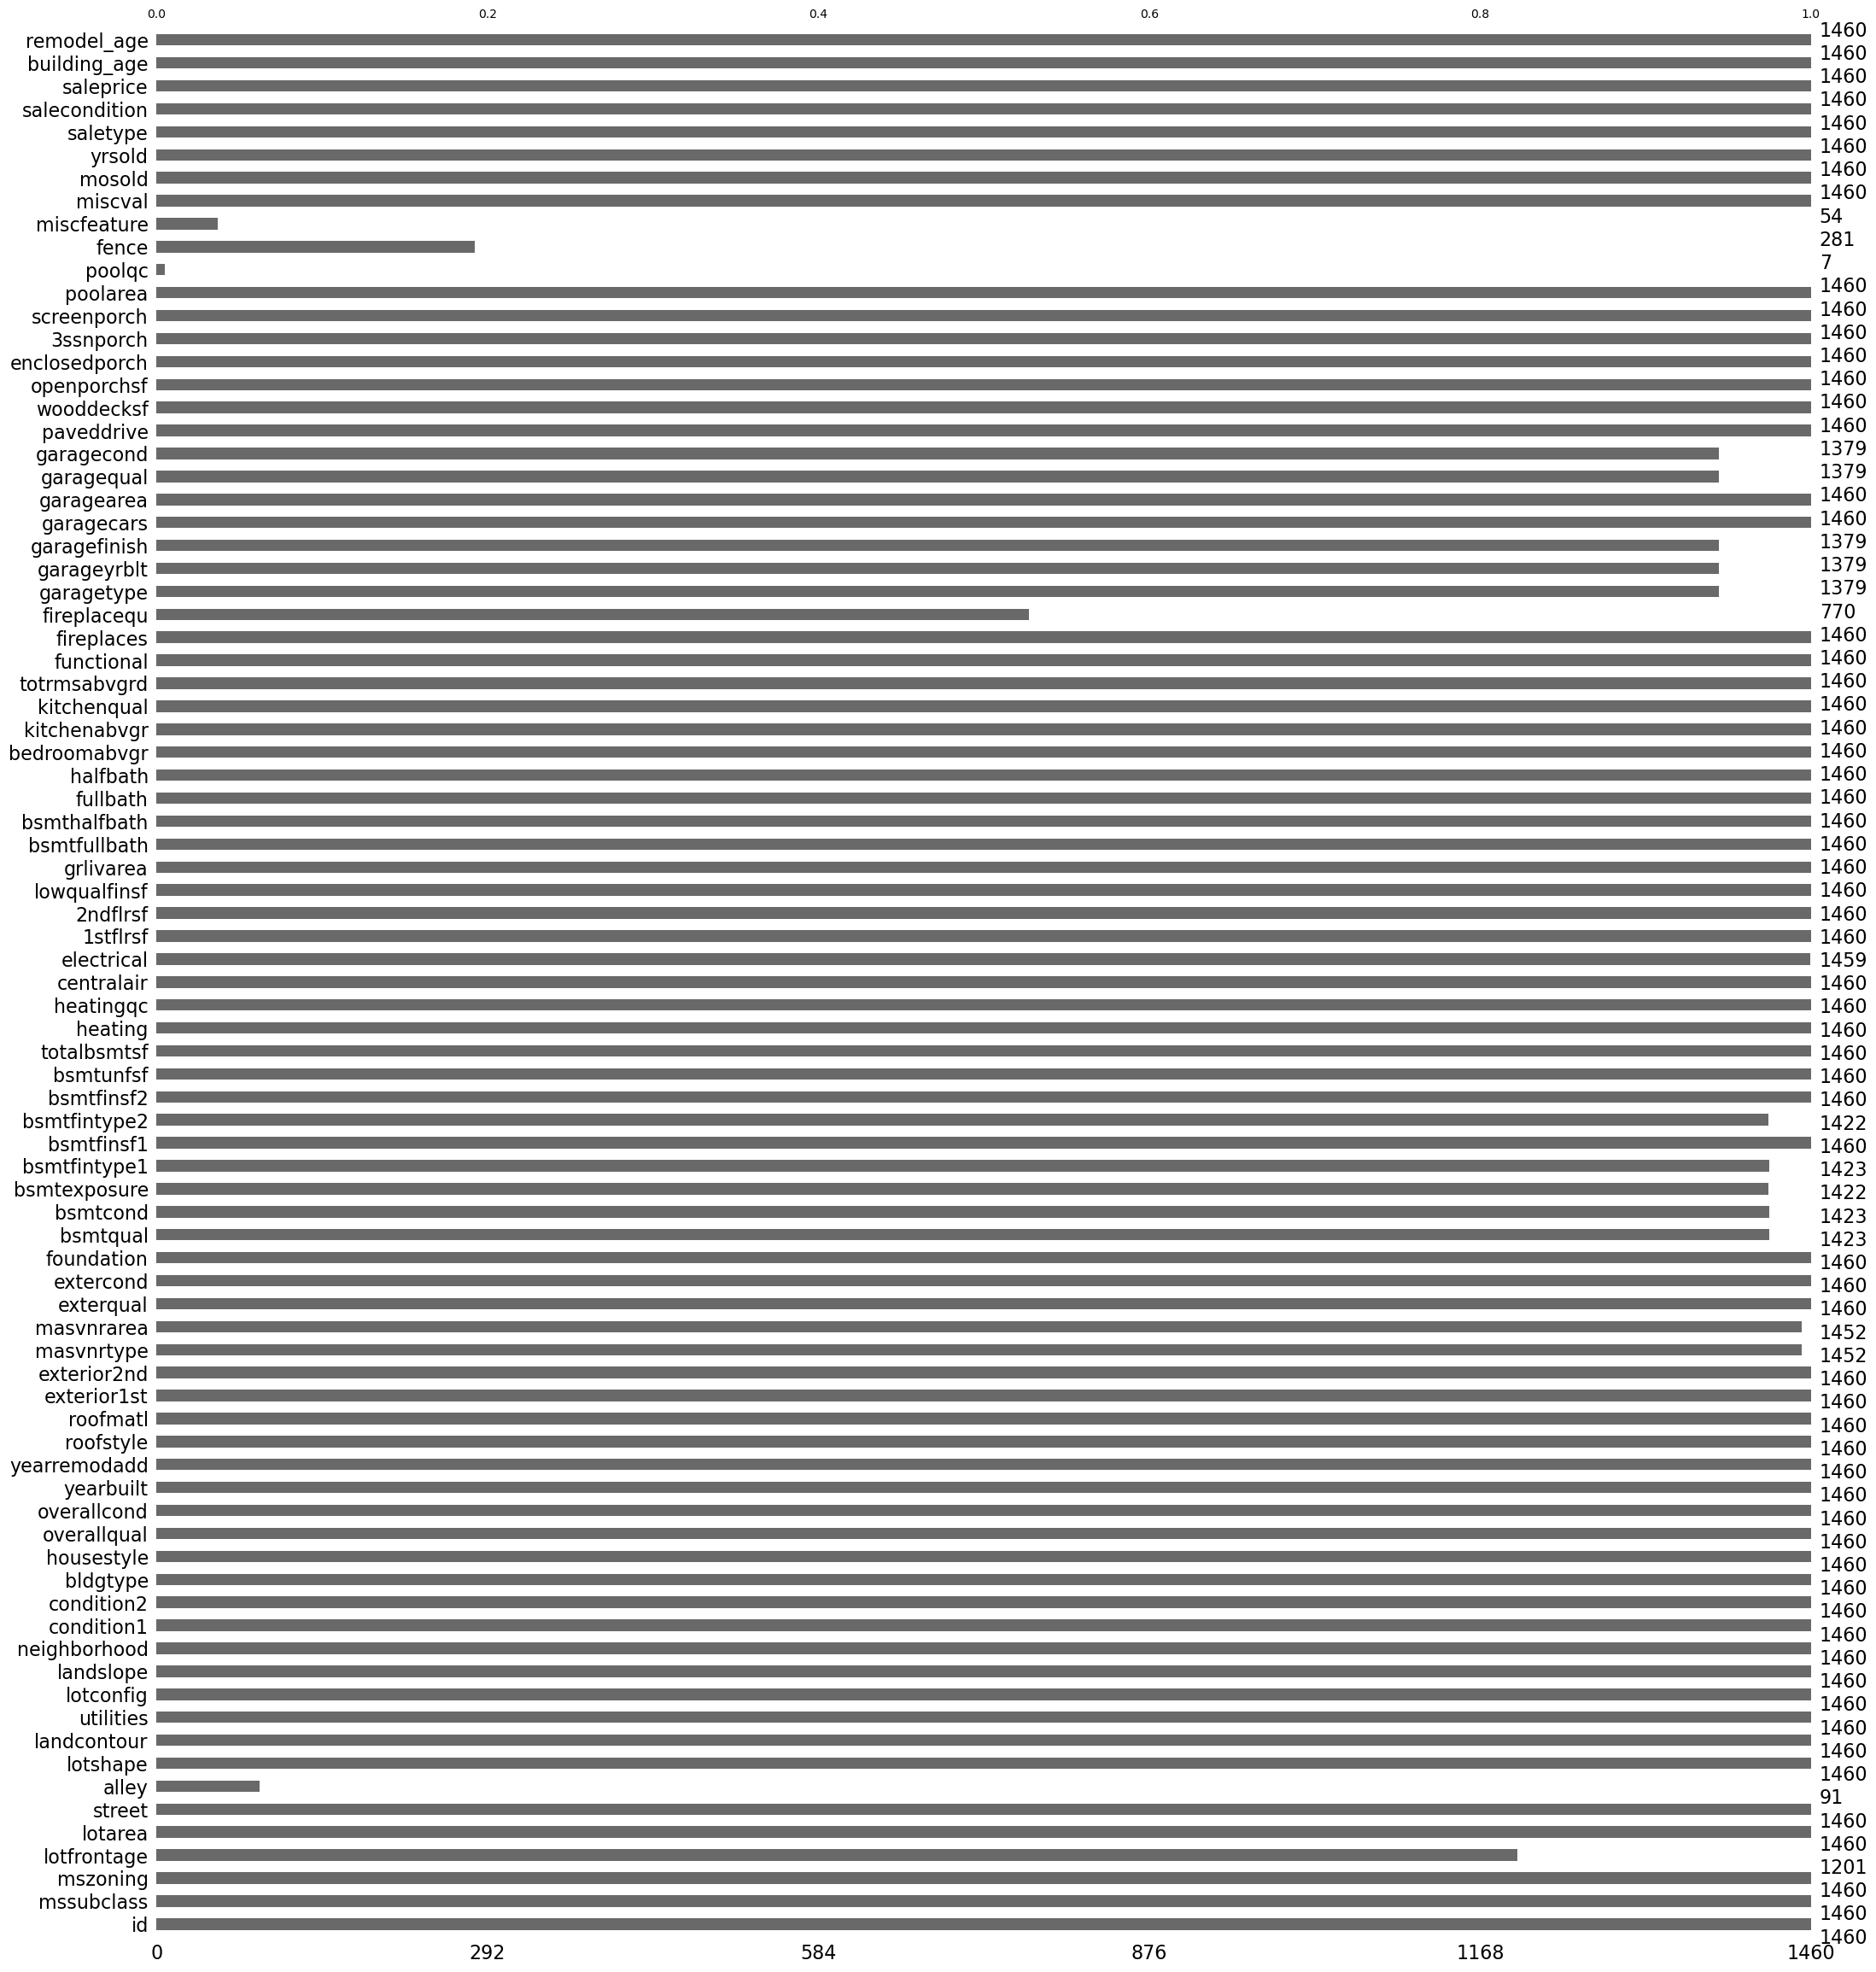

In [38]:
msno.bar(
    data,
    # filter="top",  # select only features that have a completion rate >= p
    p=MODEL_PARAMS["MIN_COMPLETION_RATE"] # filter columns with % of missing values > 50%
)

In [39]:
# Target: stat description
data[TARGET_NAME].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: saleprice, dtype: float64

**Features**:
- 'bsmtfinsf1': 
- 'bsmtunfsf': 
- 'condition2': 
- 'exterqual': 
- 'foundation': 
- 'garagecars': 
- 'garagetype': 
- 'heating': 
- 'heatingqc': 
- 'housestyle': 
- 'lotarea': 
- 'masvnrarea': 
- 'masvnrtype': 
- 'miscfeature': 
- 'mosold': 
- 'mssubclass':
- 'mszoning'
- 'overallqual': 
- 'street': 
- 'totalbsmtsf'
- 'yearremodadd'
- 'yrsold'
- 'mosold',  # Month Sold (MM)
- "yearbuilt",  # Original construction date
- "yearremodadd",  # Remodel date (same as construction date if no remodeling or additions)|
- 'yrsold',  # Year Sold (YYYY)

**Target**: "saleprice"

In [40]:
data.columns

Index(['id', 'mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street',
       'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig',
       'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype',
       'housestyle', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd',
       'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype',
       'masvnrarea', 'exterqual', 'extercond', 'foundation', 'bsmtqual',
       'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1',
       'bsmtfintype2', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating',
       'heatingqc', 'centralair', 'electrical', '1stflrsf', '2ndflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
       'totrmsabvgrd', 'functional', 'fireplaces', 'fireplacequ', 'garagetype',
       'garageyrblt', 'garagefinish', 'garagecars', 'garagearea', 'garagequal',
       'garagecond', 'paveddrive

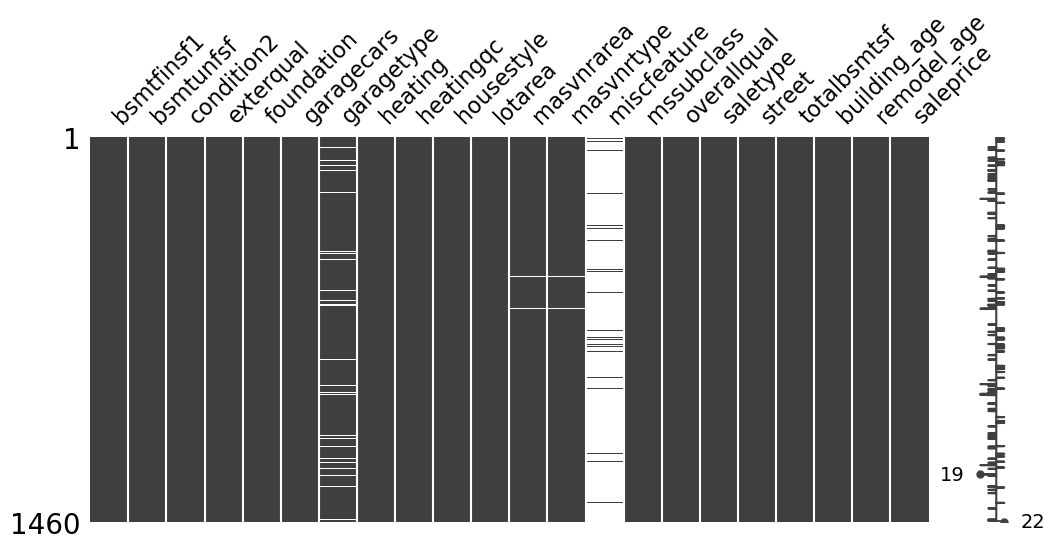

In [41]:
msno.matrix(data.loc[:, FEATURES + [TARGET_NAME]], figsize=(12, 5));

In [42]:
categorical_features = data.select_dtypes(include="object").columns
print(f"Categorical features:\n {categorical_features}\n")

numerical_features = data.select_dtypes(include="number").columns
print(f"Numerical features:\n {numerical_features}")

Categorical features:
 Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')

Numerical features:
 Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', '1stflrsf', '2ndflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'f

ncols = 2  # number of columns in subplot
nrows = sum(divmod(len(categorical_features), ncols))  # number of rows
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 30))
axes = axes.ravel()

for i, col_name in enumerate(categorical_features):
    ax = axes[i]
    sns.violinplot(x=col_name, y=TARGET_NAME, data=data, palette='husl', ax=ax)

In [43]:
pd.crosstab(index=data.housestyle, columns=data.heating, margins=True, margins_name="Total", dropna=False)

heating,Floor,GasA,GasW,Grav,OthW,Wall,Total
housestyle,,,,,,,
1.5Fin,0,143,7,3,0,1,154
1.5Unf,0,12,0,2,0,0,14
1Story,1,715,5,2,0,3,726
2.5Fin,0,8,0,0,0,0,8
2.5Unf,0,8,2,0,1,0,11
2Story,0,440,4,0,1,0,445
SFoyer,0,37,0,0,0,0,37
SLvl,0,65,0,0,0,0,65
Total,1,1428,18,7,2,4,1460


In [44]:
px.box(data_frame=data, x="heating", y=TARGET_NAME)

In [45]:
px.box(
    data_frame=data, y=TARGET_NAME,
    x="housestyle", color="heating",
    title="Box plot",
    #hover_data=[Heating"],
    boxmode="group",
    #notched=True, # used notched shape
    points=None,
    width=900,
    height=500,
)

<AxesSubplot:xlabel='heating', ylabel='housestyle'>

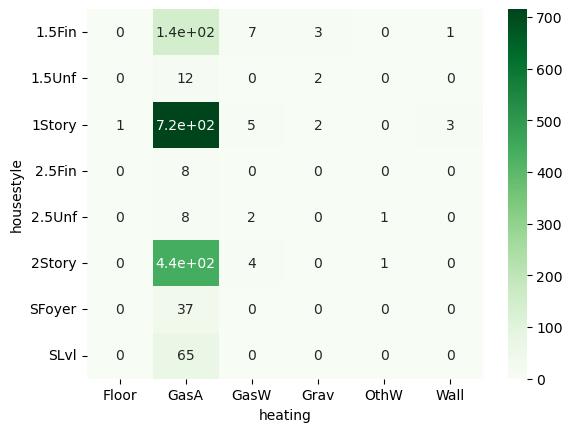

In [46]:
sns.heatmap(
    pd.crosstab(
        index=data.housestyle, columns=data.heating,
        margins=False,
        margins_name="Total", 
        dropna=False
    ),
    cmap="Greens", 
    annot=True,
    fmt='.2g',
)

<AxesSubplot:xlabel='totalbsmtsf', ylabel='saleprice'>

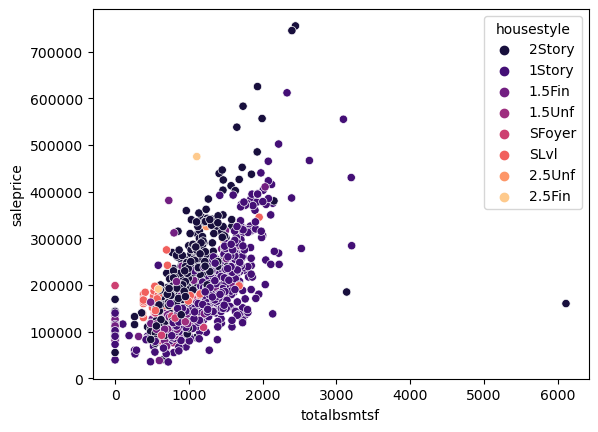

In [47]:
sns.scatterplot(x='totalbsmtsf', y=TARGET_NAME, data=data, palette='magma', hue='housestyle')

In [48]:
#Path(REPORT_DIR).mkdir(parents=True, exist_ok=True)

#profile = ProfileReport(data, title="House price - profiling")
# profile.to_notebook_iframe()
#profile.to_file(Path(REPORT_DIR, 'profiling_report.html'))

# Feature engineering / selections

In [49]:
data.loc[:, ["yrsold", "mosold", "yearbuilt", "yearremodadd"]]

,yrsold,mosold,yearbuilt,yearremodadd
0,2008.0,2.0,2003.0,2003.0
1,2007.0,5.0,1976.0,1976.0
2,2008.0,9.0,2001.0,2002.0
3,2006.0,2.0,1915.0,1970.0
4,2008.0,12.0,2000.0,2000.0
...,...,...,...,...
1455,2007.0,8.0,1999.0,2000.0
1456,2010.0,2.0,1978.0,1988.0
1457,2010.0,5.0,1941.0,2006.0
1458,2010.0,4.0,1950.0,1996.0


In [50]:
data.yearbuilt.value_counts().head(10) #plot(kind="bar", figsize=(15, 7));

yearbuilt
2006.0    67
2005.0    64
2004.0    54
2007.0    49
2003.0    45
1976.0    33
1977.0    32
1920.0    30
1959.0    26
1998.0    25
Name: count, dtype: int64

In [51]:
data.shape

(1460, 83)

In [52]:
filtered_data = filter_variables_by_completion_rate(data)

2023-08-21 13:33:32.272 | INFO     | src.utils:filter_variables_by_completion_rate:39 - 
 percentage of missing values: id               0.000000
mssubclass       0.000000
mszoning         0.000000
lotfrontage      0.177397
lotarea          0.000000
                   ...   
saletype         0.000000
salecondition    0.000000
saleprice        0.000000
building_age     0.000000
remodel_age      0.000000
Length: 83, dtype: float64


In [54]:
filtered_data.shape

(1460, 79)

<AxesSubplot:>

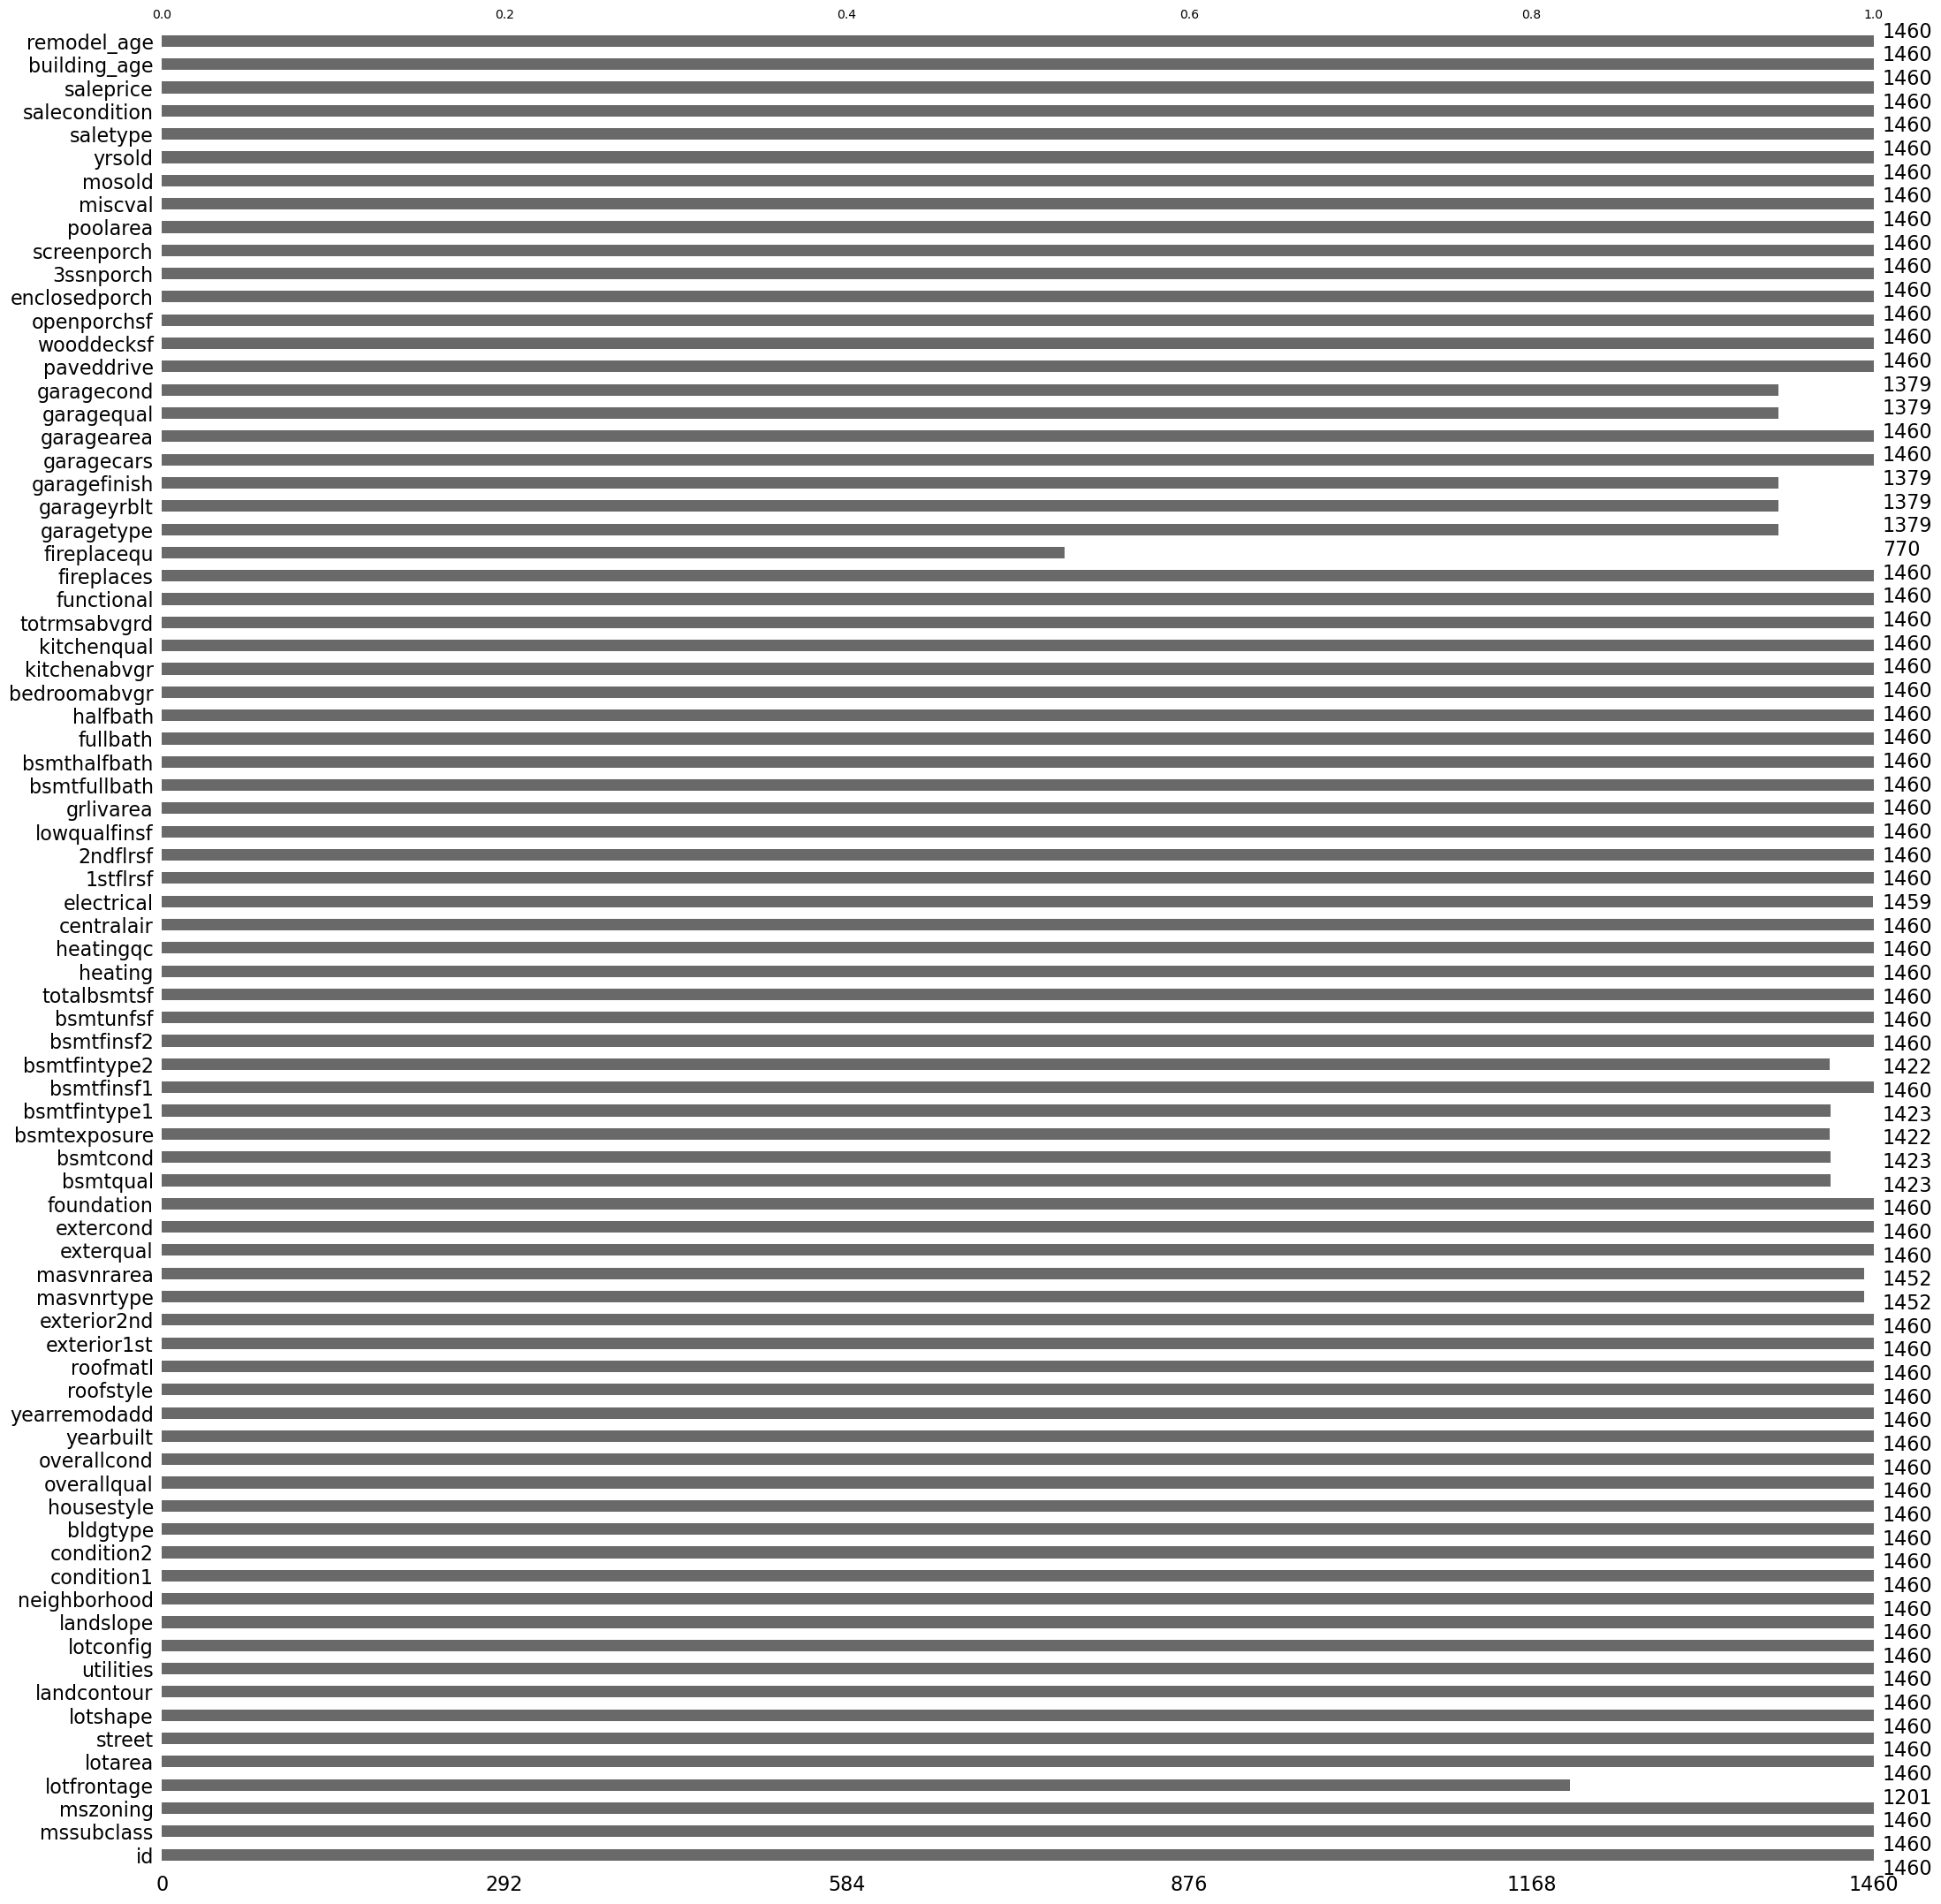

In [55]:
msno.bar(
    filtered_data,
    # filter="top",  # select only features that have a completion rate >= p
    p=MODEL_PARAMS["MIN_COMPLETION_RATE"] # filter columns with % of missing values > 50%
)

In [56]:
filtered_data=remove_single_modality_categorical_variables(filtered_data)

2023-08-21 13:34:30.886 | INFO     | src.utils:remove_single_modality_categorical_variables:68 - 
 unique values count for mszoning: 5
2023-08-21 13:34:30.888 | INFO     | src.utils:remove_single_modality_categorical_variables:68 - 
 unique values count for street: 2
2023-08-21 13:34:30.889 | INFO     | src.utils:remove_single_modality_categorical_variables:68 - 
 unique values count for lotshape: 4
2023-08-21 13:34:30.890 | INFO     | src.utils:remove_single_modality_categorical_variables:68 - 
 unique values count for landcontour: 4
2023-08-21 13:34:30.891 | INFO     | src.utils:remove_single_modality_categorical_variables:68 - 
 unique values count for utilities: 2
2023-08-21 13:34:30.892 | INFO     | src.utils:remove_single_modality_categorical_variables:68 - 
 unique values count for lotconfig: 5
2023-08-21 13:34:30.893 | INFO     | src.utils:remove_single_modality_categorical_variables:68 - 
 unique values count for landslope: 3
2023-08-21 13:34:30.894 | INFO     | src.utils:remo

In [57]:
filtered_data = filtered_data.drop("id", axis=1) #drop id by the same way

In [61]:
filtered_data.head()

,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice,building_age,remodel_age
0,60.0,RL,65.0,8450.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2003.0,2003.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,Gd,8.0,Typ,0.0,None,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,WD,Normal,208500.0,5.0,5.0
1,20.0,RL,80.0,9600.0,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6.0,8.0,1976.0,1976.0,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,TA,6.0,Typ,1.0,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,WD,Normal,181500.0,31.0,31.0
2,60.0,RL,68.0,11250.0,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2001.0,2002.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,Gd,6.0,Typ,1.0,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,WD,Normal,223500.0,7.0,6.0
3,70.0,RL,60.0,9550.0,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7.0,5.0,1915.0,1970.0,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,Gd,7.0,Typ,1.0,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,WD,Abnorml,140000.0,91.0,36.0
4,60.0,RL,84.0,14260.0,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8.0,5.0,2000.0,2000.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,Gd,9.0,Typ,1.0,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,WD,Normal,250000.0,8.0,8.0


# Saving cleaned dataset

In [60]:
nom_fichier = "cleaned_data"
save_dataset(filtered_data, nom_fichier)

Dataset sauvegardé avec succès sous /Users/ahmadou-bamba/Desktop/TP_house_pricing_CHEIKH_AHMADOU_BAMBA_DIOP/data/input/cleaned_data.pkl
